In [3]:
# Generate the list of installed packages to export to GitHub

import subprocess

# Run pip freeze command to get the list of installed packages
result = subprocess.run(['pip', 'freeze'], stdout=subprocess.PIPE)

# Decode the output and split it into lines
packages = result.stdout.decode('utf-8').split('\n')

# Print the packages to the console
for package in packages:
    print(package)

act-atmos==1.5.2
antlr4-python3-runtime==4.7.2
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.0
attrs==23.1.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.1.0
Cartopy==0.22.0
certifi==2023.7.22
cf-units==3.2.0
cffi==1.16.0
cftime==1.6.2
charset-normalizer==3.3.0
click==8.1.7
cloudpickle==3.0.0
cmweather==0.1.0
colorama==0.4.6
comm==0.1.4
contourpy==1.1.1
cycler==0.12.1
dask==2023.10.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
distributed==2023.10.0
emc2==1.3.0
executing==2.0.0
fastjsonschema==2.18.1
fonttools==4.43.1
fqdn==1.5.1
fsspec==2023.9.2
fuzzywuzzy==0.18.0
gini==0.7
gitdb==4.0.11
GitPython==3.1.40
idna==3.4
importlib-metadata==6.8.0
install==1.3.5
ipykernel==6.25.2
ipython==8.16.1
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.2
joblib==1.3.2
jplephem==2.19
jsonpointer==2.4
jsonschema==4.19.2
jsonschema-specifications==2023.7.1
jupyter-events==0.9.0
jupyter-server-mathjax==0.2.6
jupyter_client==8.4.0
jupyter_core==5.4.0
jupy

# File saving

In [2]:
# um_emc2_main function
##############################
# The purpose of this function is to process and re-save UM regional model output so that it is ready to use with the Earth Model Column Collaboratory (EMC2) instrument simulator.
# This function processes one day of data at daily or higher resolution. To process multiple days, we recommend constructing a wrapper for this function as follows:
# for parent_folder, date, output_folder, latitudes, longitudes in list_of_inputs:
#     um_emc2_main(parent_folder = parent_folder, date = date, output_folder = output_folder, latitudes = latitudes, longitudes = longitudes)
# The output will a single .nc file saved to the output path at native model time and height resolution and with one horizontal grid cell of data.
# The horizonal grid cell will either be a fixed point (len(latitudes) == len(longitudes) == 1) or a moving point (len(latitudes) ==  len(longitudes) > 1).
# This function requires um_emc2_input_validator, um_emc2_dictionary_sorter, um_emc2_data_processor, and um_emc2_final_saver to execute suucessfully.
##############################
# Inputs:
# a parent folder containing all data to read (the data files to read must be either .nc or .pp format);
# a date for a single day as either a string ('YYYYMMDD') or datetime object;
# an output path; and
# an xarray dataset containing latitude and longitude variables as a function of a datetime coordinate
##############################

# Import packages
import os # for interacting with the operating system
import re # for pattern matching
import glob # for pattern matching in file lists
import xarray as xr # for general dataset file handling
import pandas as pd # for additional data handling
import netCDF4 as nc # for NetCDF file handling
import numpy as np # for scientific computing
import emc2
from emc2.core import Instrument
from emc2.core.instrument import ureg
from datetime import datetime

# Define the um_emc2_main function
def um_emc2_main(date, parent_folder, output_folder, coordinates):
    
    # FROM FUNCTIONS.PY IMPORT *, SCRIPT CONTAINING ALL FUNCTIONS CALLED BY MAIN

    # Validate the input, including the date, parent and output folders, coordinates, and types of files to process, and return the lists of unsorted .nc and .pp files to process
    date, date_str, coordinates, files_list_nc, files_list_pp = um_emc2_input_validator(date = date, parent_folder = parent_folder, output_folder = output_folder, coordinates = coordinates)
    print('um_emc2_input_validator executed successfully')
    print()
    
    # Pass file lists to the sorting function and return the sorted dictionary
    filenames_dict = um_emc2_dictionary_sorter(files_list_nc = files_list_nc, files_list_pp = files_list_pp)
    print('um_emc2_dictionary_sorter executed successfully')
    print()

    # Process the data - extract only relevant variables, limit time and spatial domains, and save partial files in the output folder
    um_emc2_data_processor(date = date, date_str = date_str, parent_folder = parent_folder, output_folder = output_folder, filenames_dict = filenames_dict, coordinates = coordinates)
    print('um_emc2_data_processor executed successfully')
    print()

    # Save the final data file for the selected day
    um_emc2_final_saver(date_str, output_folder)
    print('um_emc2_final_saver executed successfully')
    print()

    print('um_emc2_main executed successfully')

In [87]:
# Define the um_emc2_input_validator function
def um_emc2_input_validator(date, parent_folder, output_folder, coordinates):

    # Date check
    # If the date is a string, check whether the format is valid and convert it to datetime object
    if isinstance(date, str):
        try:
            date = datetime.strptime(date, '%Y%m%d')
        except ValueError:
            raise ValueError('Invalid date format. Please provide a date in "YYYYMMDD" format')
        date_str = date.strftime('%Y%m%d')
    # If the date is a datetime, create a string version
    elif isinstance(date, datetime):
        date_str = date.strftime('%Y%m%d')
    else:
        raise ValueError('Input date must be a string or a datetime object')
    
    # Parent folder check
    if not os.path.isdir(parent_folder):
        raise ValueError(f'parent_folder "{parent_folder}" is not a valid directory.')
    
    # Output path check
    if not os.path.isdir(output_folder):
        raise ValueError(f'output_folder "{output_folder}" is not a valid directory.')
    
    # Coordinates check
    # Check for latitude and longitude variables
    # Find variables with appropriate strings
    lat_var = [var for var in coordinates.data_vars if 'lat' in var]
    lon_var = [var for var in coordinates.data_vars if 'lon' in var]
    # Raise an exception if a latitude or longitude variable is not found or if more than one such variable is found
    if not lat_var or not lon_var:
        raise ValueError('Latitude or longitude variable not found')
    if len(lat_var) > 1 or len(lon_var) > 1:
        raise ValueError('More than one latitude or longitude variable found')
    # Rename the latitude and longitude variables
    coordinates = coordinates.rename({lat_var[0]: 'latitude', lon_var[0]: 'longitude'})
    # Check for datetime variable
    # Find variable of type datetime
    datetime_var = [var for var in coordinates.coords if coordinates[var].dtype == 'datetime64[ns]']
    # Raise an exception if no datetime variable is found or if more than one such variable is found
    if not datetime_var:
        raise ValueError('Datetime type variable not found')
    if len(datetime_var) > 1:
        raise ValueError('More than one datetime variable found')
    # Rename datetime variable to 'coordinate_datetime'
    coordinates = coordinates.rename({datetime_var[0]: 'coordinate_datetime'})
    
    # File type check
    # Create the list of all files in the parent folder
    # Check what types of files need to be processed
    files_list_nc = []
    files_list_pp = []
    for root, dirs, filenames in os.walk(parent_folder):
        for filename in filenames:
            if filename.endswith('.nc'):
                files_list_nc.append(os.path.join(root, filename))
            elif not os.path.splitext(filename)[1]:
                files_list_pp.append(os.path.join(root, filename))
            else:
                print(f'{filename} is an unrecognized filetype and will not be processed')
    # Print numbers and types of files found
    if files_list_nc:
        print(f'{len(files_list_nc)} .nc files found')
    if files_list_pp:
        # Iris is required to load .pp files
        import iris
        print(f'{len(files_list_pp)} .pp files found')
    if not files_list_nc and not files_list_pp:
        raise ValueError('No files of either .nc or other type found')
    if files_list_nc and files_list_pp:
        print('Warning: Multiple file types detected; code will proceeed, but we recommend ensuring uniformity of file types for simplicity of error diagnosis')

    print()
    return(date, date_str, coordinates, files_list_nc, files_list_pp)

In [88]:
# Define the um_emc2_dictionary_sorter function
def um_emc2_dictionary_sorter(files_list_nc, files_list_pp):

    # Create the dictionary of files sorted by numerical code (presumably time) in the base filename
    # Create a unified files list
    files_list_all = files_list_nc + files_list_pp
    filenames_list = [os.path.basename(filename) for filename in files_list_all]
    # Initialize the dictionary
    filenames_dict = {}
    for filename in filenames_list:
        # If the file type .nc, strip the extension first
        if filename.endswith('.nc'):
            filename_base = os.path.splitext(filename)[0]
        # If the file type is absent, the file is presumed .pp type
        else:
            filename_base = filename
        # If the numeric block is already a key in the dictionary, append the filename including the extension
        # Otherwise, create a new list with the filename as the value for that key
        numeric_blocks = re.findall(r'\d+', filename_base)
        for numeric_block in numeric_blocks:
            if numeric_block in filenames_dict:
                filenames_dict[numeric_block].append(filename)
            else:
                filenames_dict[numeric_block] = [filename]
    # Sort filenames within each numeric block
    for numeric_block, filenames in filenames_dict.items():
        filenames_dict[numeric_block] = sorted(filenames)
    # Sort blocks/keys by number
    filenames_dict = dict(sorted(filenames_dict.items(), key=lambda item: int(item[0])))
    # Print the keys and files
    for key, items in filenames_dict.items():
        print(key)
        for item in items:
            print(item)

    print()
    return(filenames_dict)

In [89]:
# Define the um_emc2_data_processor function
def um_emc2_data_processor(parent_folder, date, date_str, output_folder, filenames_dict, coordinates):

    # Create the list of variables to look for
    required_variables = ['mass_fraction_of_cloud_liquid_water_in_air','mass_fraction_of_cloud_ice_in_air','mass_fraction_of_rain_in_air','mass_fraction_of_cloud_ice_crystals_in_air','mass_fraction_of_graupel_in_air',
    'number_of_cloud_droplets_per_kg_of_air','number_of_ice_particles_per_kg_of_air','number_of_rain_drops_per_kg_of_air','number_of_snow_aggregates_per_kg_of_air','number_of_graupel_particles_per_kg_of_air',
    'cloud_area_fraction_in_atmosphere_layer','air_pressure','air_temperature','specific_humidity']
    required_coordinates = ['level_height','time','model_level_number','grid_latitude','grid_longitude']
    variables_to_keep = required_variables + required_coordinates
    # Loop across all file groups defined by dictionary keys
    for key in list(filenames_dict.keys()):
        # Create the list of current_files
        current_items = filenames_dict[key]
        # Identify the current key
        print(f'Now searching {key} files...')
        # Reset the key_dataset
        key_dataset = xr.Dataset()
        # Reset the breaker
        break_current = False
        # Reset the list of variables found
        variables_found = []
        # Loop across all current files
        for file in current_items:
            # Check the file type and handle accordingly
            # If the filetype is .nc...
            if file.endswith('.nc'):
                # Load the current dataset
                dataset = xr.open_dataset(f'{parent_folder}/{file}')
                print(f'Now searching {file}...')
                # Check whether the data contains a time coordinate
                if 'time' not in dataset:
                    print('No time coordinate found - skipping current file...')
                    continue
                # Remove the time component from the date
                date_only = np.datetime64(date, 'D')
                # Select time values within the current date
                time_within_date = dataset.time.where((dataset.time.dt.floor('D') == date_only), drop=True)
                # Check whether dataset uses time as an index
                try:
                    dataset = dataset.sel(time=time_within_date)
                except KeyError:
                    print('No index found for coordinate time - skipping current file...')
                    continue
                # Check whether any data remains
                if len(dataset.time) == 0:
                    print(f'{file} in {key} block has no data inside current date - skipping current key...')
                    break_current = True
                    break
                # Check whether the dataset contains any of the required variables
                if any(var in dataset.variables for var in required_variables):
                    # Drop variables not in required_variables or required_coordinates
                    dataset = dataset.drop_vars([var for var in dataset.variables if var not in variables_to_keep])
                    # Loop across the variables in the dataset
                    for var in dataset:
                        # Is the variable required?
                        if var in required_variables:
                            # Has the variable already been found in the current key?
                            if var in variables_found:
                                # Drop the variable from the dataset
                                dataset = dataset.drop_vars(var)
                            else:
                                print(f'{var} found in {file}')
                                # Add the variable to the list of found variables
                                variables_found += [var]
                    # Check whether the dataset still contains any of the required variables
                    if any(var in dataset.variables for var in required_variables):
                        # Subset the dataset to the coordinates location
                        # Create an empty list to store the dataset subsets
                        subset_dataset_list = []
                        # Create empty lists to store latitudes and longitudes
                        lat_values, lon_values = [], []
                        # Iterate over each time value in the dataset
                        for time_value in dataset['time']:
                            # Create a dataset containing only values at 'time_value'
                            dataset_current_time = dataset.sel(time=time_value)
                            # Find the closest coordinate_datetime in the coordinates
                            closest_coordinate_datetime = coordinates['coordinate_datetime'].sel(coordinate_datetime = time_value, method = 'nearest').values
                            # Find the corresponding latitude and longitude values
                            lat_value = coordinates['latitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
                            lon_value = coordinates['longitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
                            # Find the grid_latitude and grid_longitude values in the dataset closest to lat_value and lon_value
                            closest_lat_idx = np.argmin(np.abs(dataset_current_time['grid_latitude'].values - lat_value))
                            closest_lon_idx = np.argmin(np.abs(dataset_current_time['grid_longitude'].values - lon_value))
                            # Subset the dataset based on the closest grid_latitude and grid_longitude values
                            subset = dataset_current_time.isel(grid_latitude=closest_lat_idx, grid_longitude=closest_lon_idx)
                            # Save the current grid_latitude and grid_longitude values
                            lat_values.append(lat_value)
                            lon_values.append(lon_value)
                            # lat_values.append(subset['grid_latitude'].values)
                            # lon_values.append(subset['grid_longitude'].values)
                            # Drop latitude and longitude from the subset
                            subset = subset.drop_vars('grid_latitude')
                            subset = subset.drop_vars('grid_longitude')
                            # Append the subset to the list
                            subset_dataset_list.append(subset)
                        # Concatenate the subsets along a new dimension
                        subset_dataset = xr.concat(subset_dataset_list, dim='time')
                        # Add latitudes and longitudes as variables
                        lat_values = xr.DataArray(data=lat_values, dims='dim_name')
                        lon_values = xr.DataArray(data=lon_values, dims='dim_name')
                        subset_dataset['latitude'] = ('time', lat_values.data)
                        subset_dataset['longitude'] = ('time', lon_values.data)
                        # Merge the subset_dataset with the key_dataset
                        key_dataset = key_dataset.merge(subset_dataset)
                        print(f'File {file} merged')
                    else:
                        # No variables found?
                        print(f'{file} contains no required variables')
                else:
                    # No variables found?
                    print(f'{file} contains no required variables')
            # If the filetype is not .nc...
            else:
                # Load the current dataset using iris
                iris_cubes = iris.load(f'{parent_folder}/{file}')
                # Initialize an empty dataset
                dataset = xr.Dataset()
                print(f'Now searching {file}...')
                # Iterate over the variables in iris_cubes to create the dataset
                for i, f in enumerate(iris_cubes):
                    # Create the temporary dataset
                    temp_dataset = xr.DataArray.from_iris(iris_cubes[i])                
                    # Check whether the temp_dataset current variable is required
                    if temp_dataset.name in required_variables:
                        # Check whether the variable has already been found
                        if temp_dataset.name not in variables_found:
                            try:
                                dataset = dataset.merge(temp_dataset)
                            except xr.MergeError as e:
                                if 'conflicting values for variable \'level_height\'' in str(e):
                                    print(f'Warning: Conflicing values detected for variable "level_height" in {temp_dataset.name}; compat="override" used')
                                    dataset = dataset.merge(temp_dataset, compat='override')
                                elif 'conflicting values for variable \'forecast_period\'' in str(e):
                                    print(f'Warning: Conflicing values detected for variable "forecast_period" in {temp_dataset.name}; compat="override" used')
                                    dataset = dataset.merge(temp_dataset, compat='override')
                                elif 'conflicting values for variable \'forecast_reference_time\'' in str(e):
                                    print(f'Warning: Conflicing values detected for variable "forecast_reference_time" in {temp_dataset.name}; compat="override" used')
                                    dataset = dataset.merge(temp_dataset, compat='override')
                                elif 'conflicting values for variable \'height\'' in str(e):
                                    print(f'Warning: Conflicing values detected for variable "height" in {temp_dataset.name}; compat="override" used')
                                    dataset = dataset.merge(temp_dataset, compat='override')
                                elif 'conflicting values for variable \'level_height\'' in str(e):
                                    print(f'Warning: Conflicing values detected for variable "level_height" in {temp_dataset.name}; compat="override" used')
                                    dataset = dataset.merge(temp_dataset, compat='override')
                                else:
                                    raise e
                            except AttributeError as e:
                                print(f"Skipping variable {temp_dataset.name}: {e}...")
                                continue  # Skip this iteration and continue with the next one
                            except ValueError as e:
                                if "Unpacking PP fields with LBPACK of 1 requires mo_pack to be installed" in str(e):
                                    print("Warning: mo_pack is not installed; skipping the current loop iteration...")
                                    continue  # Skip the current iteration and move to the next one
                                else:
                                    raise # Re-raise the error if it's not the expected one
                        print(f'{temp_dataset.name} found in {file}')
                        # Add the variable to the list of found variables
                        variables_found += [temp_dataset.name]
                        # Identify the variable found
                # Check whether the data contains a time coordinate
                if 'time' not in dataset.variables:
                    print('No time coordinate found - skipping current file...')
                    continue
                # Remove the time component from the date
                date_only = np.datetime64(date, 'D')
                # Select time values within the current day
                time_within_date = dataset.time.where((dataset.time.dt.floor('D') == date_only), drop=True)
                # Check whether dataset uses time as an index
                try:
                    dataset = dataset.sel(time=time_within_date)
                except KeyError:
                    print('No index found for coordinate time - skipping current file...')
                    continue
                # Check whether any data remains
                if len(dataset.time) == 0:
                    print(f'{file} in {key} block has no data inside current date - skipping current key...')
                    break_current = True
                    break
                # Drop variables not in required_variables or required_coordinates
                dataset = dataset.drop_vars([var for var in dataset.variables if var not in variables_to_keep])
                # Check whether the dataset still contains any of the required variables
                if any(var in dataset.variables for var in required_variables):
                    # Subset the dataset to the coordinates location
                    # Create an empty list to store the dataset subsets
                    subset_dataset_list = []
                    # Create empty lists to store latitudes and longitudes
                    lat_values, lon_values = [], []
                    # Iterate over each time value in the dataset
                    for time_value in dataset['time']:
                        # Create a dataset containing only values at 'time_value'
                        dataset_current_time = dataset.sel(time=time_value)
                        # Find the closest coordinate_datetime in the coordinates
                        closest_coordinate_datetime = coordinates['coordinate_datetime'].sel(coordinate_datetime = time_value, method = 'nearest').values
                        # Find the corresponding latitude and longitude values
                        lat_value = coordinates['latitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
                        lon_value = coordinates['longitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
                        # Find the grid_latitude and grid_longitude values in the dataset closest to lat_value and lon_value
                        closest_lat_idx = np.argmin(np.abs(dataset_current_time['grid_latitude'].values - lat_value))
                        closest_lon_idx = np.argmin(np.abs(dataset_current_time['grid_longitude'].values - lon_value))
                        # Subset the dataset based on the closest grid_latitude and grid_longitude values
                        subset = dataset_current_time.isel(grid_latitude=closest_lat_idx, grid_longitude=closest_lon_idx)
                        # Save the current grid_latitude and grid_longitude values
                        lat_values.append(lat_value)
                        lon_values.append(lon_value)
                        # lat_values.append(subset['grid_latitude'].values)
                        # lon_values.append(subset['grid_longitude'].values)
                        # Drop latitude and longitude from the subset
                        subset = subset.drop_vars('grid_latitude')
                        subset = subset.drop_vars('grid_longitude')
                        # Append the subset to the list
                        subset_dataset_list.append(subset)
                    # Concatenate the subsets along a new dimension
                    subset_dataset = xr.concat(subset_dataset_list, dim='time')
                    # Add latitudes and longitudes as variables
                    lat_values = xr.DataArray(data=lat_values, dims='dim_name')
                    lon_values = xr.DataArray(data=lon_values, dims='dim_name')
                    subset_dataset['latitude'] = ('time', lat_values.data)
                    subset_dataset['longitude'] = ('time', lon_values.data)
                    # Merge the subset_dataset with the key_dataset
                    key_dataset = key_dataset.merge(subset_dataset)
                    print(f'File {file} merged')           
                else:
                    # No variables found?
                    print(f'{file} contains no required variables')
        # If there are no data in the current date, skip the current key
        if not break_current:
            # Set the save path and save the data
            print(f'Saving the {key} data...')
            save_path = os.path.join(output_folder, f'um_emc2_test_{date_str}_{key}.nc')
            key_dataset.to_netcdf(save_path)
            print(f'File saved: {save_path}')
    
        print()

In [90]:
# Define the um_emc2_final_saver function
def um_emc2_final_saver(date_str, output_folder):

    # Define the pattern of partial files to search for
    pattern = os.path.join(output_folder, f'*{date_str}*')
    # List all partial files for the current date
    saved_partial_files = glob.glob(pattern)
    # Initialize the final dataset
    final_dataset = xr.Dataset()
    # Load each partial file and merge into the final dataset
    for file in saved_partial_files:
        temp_dataset = xr.open_dataset(file)
        final_dataset = final_dataset.merge(temp_dataset)
    
    # Create a variable filled with zeros and add to the dataset
    zeros_data = xr.DataArray(
        data = np.zeros((len(final_dataset['time']), len(final_dataset['level_height']))),
        dims = ('time', 'model_level_number'),
        coords = {'time': final_dataset['time'], 'level_height': final_dataset['level_height']}
    )
    final_dataset['zeros_var'] = zeros_data
    
    # Add a 2-dimensional z_values variable to the dataset
    level_height = final_dataset['level_height'].values
    height_data = level_height[:, np.newaxis] * np.ones(len(final_dataset['time']))
    final_dataset['height_var'] = (('level_height', 'time'), height_data)
    final_dataset['height_var'].attrs['units'] = 'meter'
    final_dataset['height_var'] = final_dataset['height_var'].transpose('time', 'level_height')
    
    # Add units to all fields
    # Mass mixing ratio
    final_dataset['mass_fraction_of_cloud_liquid_water_in_air'] = final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'])
    final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'] = final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'])
    final_dataset['mass_fraction_of_rain_in_air'] = final_dataset['mass_fraction_of_rain_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['mass_fraction_of_rain_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_rain_in_air'].attrs['units'])
    final_dataset['mass_fraction_of_cloud_ice_in_air'] = final_dataset['mass_fraction_of_cloud_ice_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['mass_fraction_of_cloud_ice_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_ice_in_air'].attrs['units'])
    final_dataset['mass_fraction_of_graupel_in_air'] = final_dataset['mass_fraction_of_graupel_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['mass_fraction_of_graupel_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_graupel_in_air'].attrs['units'])
    # Number concentration
    # Add number concentration per kilogram of air to final_dataset
    final_dataset['number_of_cloud_droplets_per_kg_of_air'] = final_dataset['number_of_cloud_droplets_per_kg_of_air']
    final_dataset['number_of_ice_particles_per_kg_of_air'] = final_dataset['number_of_ice_particles_per_kg_of_air']
    final_dataset['number_of_rain_drops_per_kg_of_air'] = final_dataset['number_of_rain_drops_per_kg_of_air']
    final_dataset['number_of_snow_aggregates_per_kg_of_air'] = final_dataset['number_of_snow_aggregates_per_kg_of_air']
    final_dataset['number_of_graupel_particles_per_kg_of_air'] = final_dataset['number_of_graupel_particles_per_kg_of_air']
    # Add units
    final_dataset['number_of_cloud_droplets_per_kg_of_air'] = final_dataset['number_of_cloud_droplets_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    final_dataset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'])
    final_dataset['number_of_ice_particles_per_kg_of_air'] = final_dataset['number_of_ice_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    final_dataset['number_of_ice_particles_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_ice_particles_per_kg_of_air'].attrs['units'])
    final_dataset['number_of_rain_drops_per_kg_of_air'] = final_dataset['number_of_rain_drops_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    final_dataset['number_of_rain_drops_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_rain_drops_per_kg_of_air'].attrs['units'])
    final_dataset['number_of_snow_aggregates_per_kg_of_air'] = final_dataset['number_of_snow_aggregates_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    final_dataset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'])
    final_dataset['number_of_graupel_particles_per_kg_of_air'] = final_dataset['number_of_graupel_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    final_dataset['number_of_graupel_particles_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_graupel_particles_per_kg_of_air'].attrs['units'])
    # Stratiform fraction
    final_dataset['cloud_area_fraction_in_atmosphere_layer'] = final_dataset['cloud_area_fraction_in_atmosphere_layer'].assign_attrs(units=ureg.meter/ureg.meter)
    final_dataset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'] = str(final_dataset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'])
    # Pressure
    final_dataset['air_pressure'] = final_dataset['air_pressure'].assign_attrs(units=ureg.pascal)
    final_dataset['air_pressure'].attrs['units'] = str(final_dataset['air_pressure'].attrs['units'])
    # Temperature
    final_dataset['air_temperature'] = final_dataset['air_temperature'].assign_attrs(units=ureg.kelvin)
    final_dataset['air_temperature'].attrs['units'] = str(final_dataset['air_temperature'].attrs['units'])
    # Specific humidity
    final_dataset['specific_humidity'] = final_dataset['specific_humidity']
    final_dataset['specific_humidity'] = final_dataset['specific_humidity'].assign_attrs(units=ureg.kg/ureg.kg)
    final_dataset['specific_humidity'].attrs['units'] = str(final_dataset['specific_humidity'].attrs['units'])
    
    # Change primary height dimension to use level_height values
    level_heights = final_dataset['level_height']
    final_dataset['model_level_number'] = level_heights
    # Remove/rename coordinates
    # final_dataset = final_dataset.drop_vars(['level_height', 'sigma', 'forecast_reference_time'])
    final_dataset = final_dataset.drop_vars(['level_height'])
    final_dataset = final_dataset.rename({'model_level_number': 'level_height'})
    
    # Add general attributes to the dataset
    # final_dataset.attrs['description'] = 'UM regional model data subsetted to the MARCUS RSV location'
    # final_dataset.attrs['authors'] = 'Calum L. Knight & Sonya L. Fiddes'
    final_dataset.attrs['creation_date'] = datetime.now().strftime('%Y-%m-%d')
    
    # Set the final filename
    final_filename = f'um_emc2_test_{date_str}.nc'
    # Save the final dataset
    final_dataset.to_netcdf(os.path.join(output_folder, final_filename))
    
    # Delete partial files
    for file in saved_partial_files:
        os.remove(file)

# Testing

In [76]:
# # Date
# # date = datetime(2018, 2, 4)
# date = '20180204'

# # Parent folder
# # parent_folder = '/g/data/jk72/ck4840/projects/um_emc2/data/um_reg_input_files'
# parent_folder = '/g/data/jk72/slf563/cylc-run/u-db930/share/cycle/20180203T1200Z/Mawson/resn_1/RAL3p2/um/processed'

# # Output folder
# output_folder = '/g/data/jk72/ck4840/projects/um_emc2/data/output'

# # Coordinates
# # coordinates = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/marcus_coordinates/marcus_coordinates_20180201_20180207_1min.nc')
# coordinates = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/marcus_coordinates/marcus_coordinates_20180201_20180207_base_1min.nc')

In [77]:
# # Date check
# # If the date is a string, check whether the format is valid and convert it to datetime object
# if isinstance(date, str):
#     try:
#         date = datetime.strptime(date, '%Y%m%d')
#     except ValueError:
#         raise ValueError('Invalid date format. Please provide a date in "YYYYMMDD" format')
#     date_str = date.strftime('%Y%m%d')
# # If the date is a datetime, create a string version
# elif isinstance(date, datetime):
#     date_str = date.strftime('%Y%m%d')
# else:
#     raise ValueError('Input date must be a string or a datetime object')

# # Parent folder check
# if not os.path.isdir(parent_folder):
#     raise ValueError(f'parent_folder "{parent_folder}" is not a valid directory.')

# # Output path check
# if not os.path.isdir(output_folder):
#     raise ValueError(f'output_folder "{output_folder}" is not a valid directory.')

# # Coordinates check
# # Check for latitude and longitude variables
# # Find variables with appropriate strings
# lat_var = [var for var in coordinates.data_vars if 'lat' in var]
# lon_var = [var for var in coordinates.data_vars if 'lon' in var]
# # Raise an exception if a latitude or longitude variable is not found or if more than one such variable is found
# if not lat_var or not lon_var:
#     raise ValueError('Latitude or longitude variable not found')
# if len(lat_var) > 1 or len(lon_var) > 1:
#     raise ValueError('More than one latitude or longitude variable found')
# # Rename the latitude and longitude variables
# coordinates = coordinates.rename({lat_var[0]: 'latitude', lon_var[0]: 'longitude'})
# # Check for datetime variable
# # Find variable of type datetime
# datetime_var = [var for var in coordinates.coords if coordinates[var].dtype == 'datetime64[ns]']
# # Raise an exception if no datetime variable is found or if more than one such variable is found
# if not datetime_var:
#     raise ValueError('Datetime type variable not found')
# if len(datetime_var) > 1:
#     raise ValueError('More than one datetime variable found')
# # Rename datetime variable to 'coordinate_datetime'
# coordinates = coordinates.rename({datetime_var[0]: 'coordinate_datetime'})

# # File type check
# # Create the list of all files in the parent folder
# # Check what types of files need to be processed
# files_list_nc = []
# files_list_pp = []
# for root, dirs, filenames in os.walk(parent_folder):
#     for filename in filenames:
#         if filename.endswith('.nc'):
#             files_list_nc.append(os.path.join(root, filename))
#         elif not os.path.splitext(filename)[1]:
#             files_list_pp.append(os.path.join(root, filename))
#         else:
#             print(f'{filename} is an unrecognized filetype and will not be processed')
# # Print numbers and types of files found
# if files_list_nc:
#     print(f'{len(files_list_nc)} .nc files found', '\n')
# if files_list_pp:
#     # Iris is required to load .pp files
#     import iris
#     print(f'{len(files_list_pp)} .pp files found', '\n')
# if not files_list_nc and not files_list_pp:
#     raise ValueError('No files of either .nc or other type found')
# if files_list_nc and files_list_pp:
#     print('Warning: Multiple file types detected; code will proceeed, but we recommend ensuring uniformity of file types for simplicity of error diagnosis')

# print()
# # return(date, date_str, files_list_nc, files_list_pp)

In [78]:
# # Create the dictionary of files sorted by numerical code (presumably time) in the base filename
# # Create a unified files list
# files_list_all = files_list_nc + files_list_pp
# filenames_list = [os.path.basename(filename) for filename in files_list_all]
# # Initialize the dictionary
# filenames_dict = {}
# for filename in filenames_list:
#     # If the file type .nc, strip the extension first
#     if filename.endswith('.nc'):
#         filename_base = os.path.splitext(filename)[0]
#     # If the file type is absent, the file is presumed .pp type
#     else:
#         filename_base = filename
#     # If the numeric block is already a key in the dictionary, append the filename including the extension
#     # Otherwise, create a new list with the filename as the value for that key
#     numeric_blocks = re.findall(r'\d+', filename_base)
#     for numeric_block in numeric_blocks:
#         if numeric_block in filenames_dict:
#             filenames_dict[numeric_block].append(filename)
#         else:
#             filenames_dict[numeric_block] = [filename]
# # Sort filenames within each numeric block
# for numeric_block, filenames in filenames_dict.items():
#     filenames_dict[numeric_block] = sorted(filenames)
# # Sort blocks/keys by number
# filenames_dict = dict(sorted(filenames_dict.items(), key=lambda item: int(item[0])))
# # Print the keys and files
# for key, items in filenames_dict.items():
#     print(key)
#     for item in items:
#         print(item)

# print()
# # return(filenames_dict)

In [79]:
# # Create the list of variables to look for
# required_variables = ['mass_fraction_of_cloud_liquid_water_in_air','mass_fraction_of_cloud_ice_in_air','mass_fraction_of_rain_in_air','mass_fraction_of_cloud_ice_crystals_in_air','mass_fraction_of_graupel_in_air',
# 'number_of_cloud_droplets_per_kg_of_air','number_of_ice_particles_per_kg_of_air','number_of_rain_drops_per_kg_of_air','number_of_snow_aggregates_per_kg_of_air','number_of_graupel_particles_per_kg_of_air',
# 'cloud_area_fraction_in_atmosphere_layer','air_pressure','air_temperature','specific_humidity']
# required_coordinates = ['level_height','time','model_level_number','grid_latitude','grid_longitude']
# variables_to_keep = required_variables + required_coordinates
# # Loop across all file groups defined by dictionary keys
# for key in list(filenames_dict.keys()):
#     # Create the list of current_files
#     current_items = filenames_dict[key]
#     # Identify the current key
#     print(f'Now searching {key} files...')
#     # Reset the key_dataset
#     key_dataset = xr.Dataset()
#     # Reset the breaker
#     break_current = False
#     # Reset the list of variables found
#     variables_found = []
#     # Loop across all current files
#     for file in current_items:
#         # Check the file type and handle accordingly
#         # If the filetype is .nc...
#         if file.endswith('.nc'):
#             # Load the current dataset
#             dataset = xr.open_dataset(f'{parent_folder}/{file}')
#             print(f'Now searching {file}...')
#             # Check whether the data contains a time coordinate
#             if 'time' not in dataset:
#                 print('No time coordinate found - skipping current file')
#                 continue
#             # Remove the time component from the date
#             date_only = np.datetime64(date, 'D')
#             # Select time values within the current date
#             time_within_date = dataset.time.where((dataset.time.dt.floor('D') == date_only), drop=True)
#             # Check whether dataset uses time as an index
#             try:
#                 dataset = dataset.sel(time=time_within_date)
#             except KeyError:
#                 print('No index found for coordinate time - skipping current file')
#                 continue
#             # Check whether any data remains
#             if len(dataset.time) == 0:
#                 print(f'{file} in {key} block has no data inside current date - skipping current key...')
#                 break_current = True
#                 break
#             # Check whether the dataset contains any of the required variables
#             if any(var in dataset.variables for var in required_variables):
#                 # Drop variables not in required_variables or required_coordinates
#                 dataset = dataset.drop_vars([var for var in dataset.variables if var not in variables_to_keep])
#                 # Loop across the variables in the dataset
#                 for var in dataset:
#                     # Is the variable required?
#                     if var in required_variables:
#                         # Has the variable already been found in the current key?
#                         if var in variables_found:
#                             # Drop the variable from the dataset
#                             dataset = dataset.drop_vars(var)
#                         else:
#                             print(f'{var} found in {file}')
#                             # Add the variable to the list of found variables
#                             variables_found += [var]
#                 # Check whether the dataset still contains any of the required variables
#                 if any(var in dataset.variables for var in required_variables):
                    
#                     # Subset the dataset to the coordinates location
#                     # Create an empty list to store the dataset subsets
#                     subset_dataset_list = []
#                     # Create empty lists to store latitudes and longitudes
#                     lat_values, lon_values = [], []
#                     # Iterate over each time value in the dataset
#                     for time_value in dataset['time']:
#                         # Create a dataset containing only values at 'time_value'
#                         dataset_current_time = dataset.sel(time=time_value)
#                         # Find the closest coordinate_datetime in the coordinates
#                         closest_coordinate_datetime = coordinates['coordinate_datetime'].sel(coordinate_datetime = time_value, method = 'nearest').values
#                         # Find the corresponding latitude and longitude values
#                         lat_value = coordinates['latitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
#                         lon_value = coordinates['longitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
#                         # Find the grid_latitude and grid_longitude values in the dataset closest to lat_value and lon_value
#                         closest_lat_idx = np.argmin(np.abs(dataset_current_time['grid_latitude'].values - lat_value))
#                         closest_lon_idx = np.argmin(np.abs(dataset_current_time['grid_longitude'].values - lon_value))
#                         # Subset the dataset based on the closest grid_latitude and grid_longitude values
#                         subset = dataset_current_time.isel(grid_latitude=closest_lat_idx, grid_longitude=closest_lon_idx)
#                         # Save the current grid_latitude and grid_longitude values
#                         lat_values.append(lat_value)
#                         lon_values.append(lon_value)
#                         # lat_values.append(subset['grid_latitude'].values)
#                         # lon_values.append(subset['grid_longitude'].values)
#                         # Drop latitude and longitude from the subset
#                         subset = subset.drop_vars('grid_latitude')
#                         subset = subset.drop_vars('grid_longitude')
#                         # Append the subset to the list
#                         subset_dataset_list.append(subset)
#                     # Concatenate the subsets along a new dimension
#                     subset_dataset = xr.concat(subset_dataset_list, dim='time')
#                     # Add latitudes and longitudes as variables
#                     lat_values = xr.DataArray(data=lat_values, dims='dim_name')
#                     lon_values = xr.DataArray(data=lon_values, dims='dim_name')
#                     subset_dataset['latitude'] = ('time', lat_values.data)
#                     subset_dataset['longitude'] = ('time', lon_values.data)
#                     # Merge the subset_dataset with the key_dataset
#                     key_dataset = key_dataset.merge(subset_dataset)
#                     print(f'File {file} merged')
#                 else:
#                     # No variables found?
#                     print(f'{file} contains no required variables')
#             else:
#                 # No variables found?
#                 print(f'{file} contains no required variables')
#         # If the filetype is not .nc...
#         else:
#             # Load the current dataset using iris
#             iris_cubes = iris.load(f'{parent_folder}/{file}')
#             # Initialize an empty dataset
#             dataset = xr.Dataset()
#             print(f'Now searching {file}...')
#             # Iterate over the variables in iris_cubes to create the dataset
#             for i, f in enumerate(iris_cubes):
#                 # Create the temporary dataset
#                 temp_dataset = xr.DataArray.from_iris(iris_cubes[i])                
#                 # Check whether the temp_dataset current variable is required
#                 if temp_dataset.name in required_variables:
#                     # Check whether the variable has already been found
#                     if temp_dataset.name not in variables_found:
#                         try:
#                             dataset = dataset.merge(temp_dataset)
#                         except xr.MergeError as e:
#                             if 'conflicting values for variable \'level_height\'' in str(e):
#                                 print(f'Warning: Conflicing values detected for variable "level_height" in {temp_dataset.name}; compat="override" used')
#                                 dataset = dataset.merge(temp_dataset, compat='override')
#                             elif 'conflicting values for variable \'forecast_period\'' in str(e):
#                                 print(f'Warning: Conflicing values detected for variable "forecast_period" in {temp_dataset.name}; compat="override" used')
#                                 dataset = dataset.merge(temp_dataset, compat='override')
#                             elif 'conflicting values for variable \'forecast_reference_time\'' in str(e):
#                                 print(f'Warning: Conflicing values detected for variable "forecast_reference_time" in {temp_dataset.name}; compat="override" used')
#                                 dataset = dataset.merge(temp_dataset, compat='override')
#                             elif 'conflicting values for variable \'height\'' in str(e):
#                                 print(f'Warning: Conflicing values detected for variable "height" in {temp_dataset.name}; compat="override" used')
#                                 dataset = dataset.merge(temp_dataset, compat='override')
#                             elif 'conflicting values for variable \'level_height\'' in str(e):
#                                 print(f'Warning: Conflicing values detected for variable "level_height" in {temp_dataset.name}; compat="override" used')
#                                 dataset = dataset.merge(temp_dataset, compat='override')
#                             else:
#                                 raise e
#                         except AttributeError as e:
#                             print(f"Skipping variable {temp_dataset.name}: {e}")
#                             continue  # Skip this iteration and continue with the next one
#                         except ValueError as e:
#                             if "Unpacking PP fields with LBPACK of 1 requires mo_pack to be installed" in str(e):
#                                 print("Warning: mo_pack is not installed; skipping the current loop iteration")
#                                 continue  # Skip the current iteration and move to the next one
#                             else:
#                                 raise # Re-raise the error if it's not the expected one
#                     print(f'{temp_dataset.name} found in {file}')
#                     # Add the variable to the list of found variables
#                     variables_found += [temp_dataset.name]
#                     # Identify the variable found
#             # Check whether the data contains a time coordinate
#             if 'time' not in dataset.variables:
#                 print('No time coordinate found - skipping current file')
#                 continue
#             # Remove the time component from the date
#             date_only = np.datetime64(date, 'D')
#             # Select time values within the current day
#             time_within_date = dataset.time.where((dataset.time.dt.floor('D') == date_only), drop=True)
#             # Check whether dataset uses time as an index
#             try:
#                 dataset = dataset.sel(time=time_within_date)
#             except KeyError:
#                 print('No index found for coordinate time - skipping current file')
#                 continue
#             # Check whether any data remains
#             if len(dataset.time) == 0:
#                 print(f'{file} in {key} block has no data inside current date - skipping current key...')
#                 break_current = True
#                 break
#             # Drop variables not in required_variables or required_coordinates
#             dataset = dataset.drop_vars([var for var in dataset.variables if var not in variables_to_keep])
#             # Check whether the dataset still contains any of the required variables
#             if any(var in dataset.variables for var in required_variables):
#                 # Subset the dataset to the coordinates location
#                 # Create an empty list to store the dataset subsets
#                 subset_dataset_list = []
#                 # Create empty lists to store latitudes and longitudes
#                 lat_values, lon_values = [], []
#                 # Iterate over each time value in the dataset
#                 for time_value in dataset['time']:
#                     # Create a dataset containing only values at 'time_value'
#                     dataset_current_time = dataset.sel(time=time_value)
#                     # Find the closest coordinate_datetime in the coordinates
#                     closest_coordinate_datetime = coordinates['coordinate_datetime'].sel(coordinate_datetime = time_value, method = 'nearest').values
#                     # Find the corresponding latitude and longitude values
#                     lat_value = coordinates['latitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
#                     lon_value = coordinates['longitude'].sel(coordinate_datetime=closest_coordinate_datetime).values
#                     # Find the grid_latitude and grid_longitude values in the dataset closest to lat_value and lon_value
#                     closest_lat_idx = np.argmin(np.abs(dataset_current_time['grid_latitude'].values - lat_value))
#                     closest_lon_idx = np.argmin(np.abs(dataset_current_time['grid_longitude'].values - lon_value))
#                     # Subset the dataset based on the closest grid_latitude and grid_longitude values
#                     subset = dataset_current_time.isel(grid_latitude=closest_lat_idx, grid_longitude=closest_lon_idx)
#                     # Save the current grid_latitude and grid_longitude values
#                     lat_values.append(lat_value)
#                     lon_values.append(lon_value)
#                     # lat_values.append(subset['grid_latitude'].values)
#                     # lon_values.append(subset['grid_longitude'].values)
#                     # Drop latitude and longitude from the subset
#                     subset = subset.drop_vars('grid_latitude')
#                     subset = subset.drop_vars('grid_longitude')
#                     # Append the subset to the list
#                     subset_dataset_list.append(subset)
#                 # Concatenate the subsets along a new dimension
#                 subset_dataset = xr.concat(subset_dataset_list, dim='time')
#                 # Add latitudes and longitudes as variables
#                 lat_values = xr.DataArray(data=lat_values, dims='dim_name')
#                 lon_values = xr.DataArray(data=lon_values, dims='dim_name')
#                 subset_dataset['latitude'] = ('time', lat_values.data)
#                 subset_dataset['longitude'] = ('time', lon_values.data)
#                 # Merge the subset_dataset with the key_dataset
#                 key_dataset = key_dataset.merge(subset_dataset)
#                 print(f'File {file} merged')           
#             else:
#                 # No variables found?
#                 print(f'{file} contains no required variables')
#     # If there are no data in the current date, skip the current key
#     if not break_current:
#         # Set the save path and save the data
#         print(f'Saving the {key} data...')
#         save_path = os.path.join(output_folder, f'um_emc2_test_{date_str}_{key}.nc')
#         key_dataset.to_netcdf(save_path)
#         print(f'File saved: {save_path}')

#     print()

In [80]:
# # Define the pattern of partial files to search for
# pattern = os.path.join(output_folder, f'*{date_str}*')
# # List all partial files for the current date
# saved_partial_files = glob.glob(pattern)
# # Initialize the final dataset
# final_dataset = xr.Dataset()
# # Load each partial file and merge into the final dataset
# for file in saved_partial_files:
#     temp_dataset = xr.open_dataset(file)
#     final_dataset = final_dataset.merge(temp_dataset)

# # Create a variable filled with zeros and add to the dataset
# zeros_data = xr.DataArray(
#     data = np.zeros((len(final_dataset['time']), len(final_dataset['level_height']))),
#     dims = ('time', 'model_level_number'),
#     coords = {'time': final_dataset['time'], 'level_height': final_dataset['level_height']}
# )
# final_dataset['zeros_var'] = zeros_data

# # Add a 2-dimensional z_values variable to the dataset
# level_height = final_dataset['level_height'].values
# height_data = level_height[:, np.newaxis] * np.ones(len(final_dataset['time']))
# final_dataset['height_var'] = (('level_height', 'time'), height_data)
# final_dataset['height_var'].attrs['units'] = 'meter'
# final_dataset['height_var'] = final_dataset['height_var'].transpose('time', 'level_height')

# # Add units to all fields
# # Mass mixing ratio
# final_dataset['mass_fraction_of_cloud_liquid_water_in_air'] = final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'])
# final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'] = final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'])
# final_dataset['mass_fraction_of_rain_in_air'] = final_dataset['mass_fraction_of_rain_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['mass_fraction_of_rain_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_rain_in_air'].attrs['units'])
# final_dataset['mass_fraction_of_cloud_ice_in_air'] = final_dataset['mass_fraction_of_cloud_ice_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['mass_fraction_of_cloud_ice_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_cloud_ice_in_air'].attrs['units'])
# final_dataset['mass_fraction_of_graupel_in_air'] = final_dataset['mass_fraction_of_graupel_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['mass_fraction_of_graupel_in_air'].attrs['units'] = str(final_dataset['mass_fraction_of_graupel_in_air'].attrs['units'])
# # Number concentration
# # Add number concentration per kilogram of air to final_dataset
# final_dataset['number_of_cloud_droplets_per_kg_of_air'] = final_dataset['number_of_cloud_droplets_per_kg_of_air']
# final_dataset['number_of_ice_particles_per_kg_of_air'] = final_dataset['number_of_ice_particles_per_kg_of_air']
# final_dataset['number_of_rain_drops_per_kg_of_air'] = final_dataset['number_of_rain_drops_per_kg_of_air']
# final_dataset['number_of_snow_aggregates_per_kg_of_air'] = final_dataset['number_of_snow_aggregates_per_kg_of_air']
# final_dataset['number_of_graupel_particles_per_kg_of_air'] = final_dataset['number_of_graupel_particles_per_kg_of_air']
# # Add units
# final_dataset['number_of_cloud_droplets_per_kg_of_air'] = final_dataset['number_of_cloud_droplets_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
# final_dataset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'])
# final_dataset['number_of_ice_particles_per_kg_of_air'] = final_dataset['number_of_ice_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
# final_dataset['number_of_ice_particles_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_ice_particles_per_kg_of_air'].attrs['units'])
# final_dataset['number_of_rain_drops_per_kg_of_air'] = final_dataset['number_of_rain_drops_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
# final_dataset['number_of_rain_drops_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_rain_drops_per_kg_of_air'].attrs['units'])
# final_dataset['number_of_snow_aggregates_per_kg_of_air'] = final_dataset['number_of_snow_aggregates_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
# final_dataset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'])
# final_dataset['number_of_graupel_particles_per_kg_of_air'] = final_dataset['number_of_graupel_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
# final_dataset['number_of_graupel_particles_per_kg_of_air'].attrs['units'] = str(final_dataset['number_of_graupel_particles_per_kg_of_air'].attrs['units'])
# # Stratiform fraction
# final_dataset['cloud_area_fraction_in_atmosphere_layer'] = final_dataset['cloud_area_fraction_in_atmosphere_layer'].assign_attrs(units=ureg.meter/ureg.meter)
# final_dataset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'] = str(final_dataset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'])
# # Pressure
# final_dataset['air_pressure'] = final_dataset['air_pressure'].assign_attrs(units=ureg.pascal)
# final_dataset['air_pressure'].attrs['units'] = str(final_dataset['air_pressure'].attrs['units'])
# # Temperature
# final_dataset['air_temperature'] = final_dataset['air_temperature'].assign_attrs(units=ureg.kelvin)
# final_dataset['air_temperature'].attrs['units'] = str(final_dataset['air_temperature'].attrs['units'])
# # Specific humidity
# final_dataset['specific_humidity'] = final_dataset['specific_humidity']
# final_dataset['specific_humidity'] = final_dataset['specific_humidity'].assign_attrs(units=ureg.kg/ureg.kg)
# final_dataset['specific_humidity'].attrs['units'] = str(final_dataset['specific_humidity'].attrs['units'])

# # Change primary height dimension to use level_height values
# level_heights = final_dataset['level_height']
# final_dataset['model_level_number'] = level_heights
# # Remove/rename coordinates
# # final_dataset = final_dataset.drop_vars(['level_height', 'sigma', 'forecast_reference_time'])
# final_dataset = final_dataset.drop_vars(['level_height'])
# final_dataset = final_dataset.rename({'model_level_number': 'level_height'})

# # Add general attributes to the dataset
# # final_dataset.attrs['description'] = 'UM regional model data subsetted to the MARCUS RSV location'
# # final_dataset.attrs['authors'] = 'Calum L. Knight & Sonya L. Fiddes'
# final_dataset.attrs['creation_date'] = datetime.now().strftime('%Y-%m-%d')

# # Set the final filename
# final_filename = f'um_emc2_test_{date_str}.nc'
# # Save the final dataset
# final_dataset.to_netcdf(os.path.join(output_folder, final_filename))

# # Delete partial files
# for file in saved_partial_files:
#     os.remove(file)

In [81]:
# final_dataset

# Execute um_emc2_main

In [82]:
# Date
date = datetime(2018, 2, 4)
# date = '20180204'

# Parent folder
parent_folder = '/g/data/jk72/ck4840/projects/um_emc2/data/um_reg_input_files'
# parent_folder = '/g/data/jk72/slf563/cylc-run/u-db930/share/cycle/20180203T1200Z/Mawson/resn_1/RAL3p2/um/processed'
# parent_folder = '/g/data/jk72/ck4840/projects/um_emc2/data/um_reg_input_files' - backup .nc files

# Output folder
output_folder = '/g/data/jk72/ck4840/projects/um_emc2/data/output'

# Coordinates
# coordinates = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/marcus_coordinates/marcus_coordinates_20180201_20180207_1min.nc')
coordinates = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/marcus_coordinates/marcus_coordinates_20180201_20180207_base_1min.nc')

In [85]:
um_emc2_main(date = date, parent_folder = parent_folder, output_folder = output_folder, coordinates = coordinates)

30 .nc files found

um_emc2_input_validator executed successfully

000
umnsaa_pa000.nc
umnsaa_palcf000.nc
umnsaa_pcloud000.nc
umnsaa_pmixing000.nc
umnsaa_pradar000.nc
umnsaa_pvera000.nc
umnsaa_pverb000.nc
umnsaa_pverc000.nc
umnsaa_pverd000.nc
umnsaa_pwind000.nc
012
umnsaa_pa012.nc
umnsaa_palcf012.nc
umnsaa_pcloud012.nc
umnsaa_pmixing012.nc
umnsaa_pradar012.nc
umnsaa_pvera012.nc
umnsaa_pverb012.nc
umnsaa_pverc012.nc
umnsaa_pverd012.nc
umnsaa_pwind012.nc
024
umnsaa_pa024.nc
umnsaa_palcf024.nc
umnsaa_pcloud024.nc
umnsaa_pmixing024.nc
umnsaa_pradar024.nc
umnsaa_pvera024.nc
umnsaa_pverb024.nc
umnsaa_pverc024.nc
umnsaa_pverd024.nc
umnsaa_pwind024.nc

um_emc2_dictionary_sorter executed successfully

um_emc2_data_processor executed successfully

um_emc2_final_saver executed successfully

um_emc2_main executed successfully


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

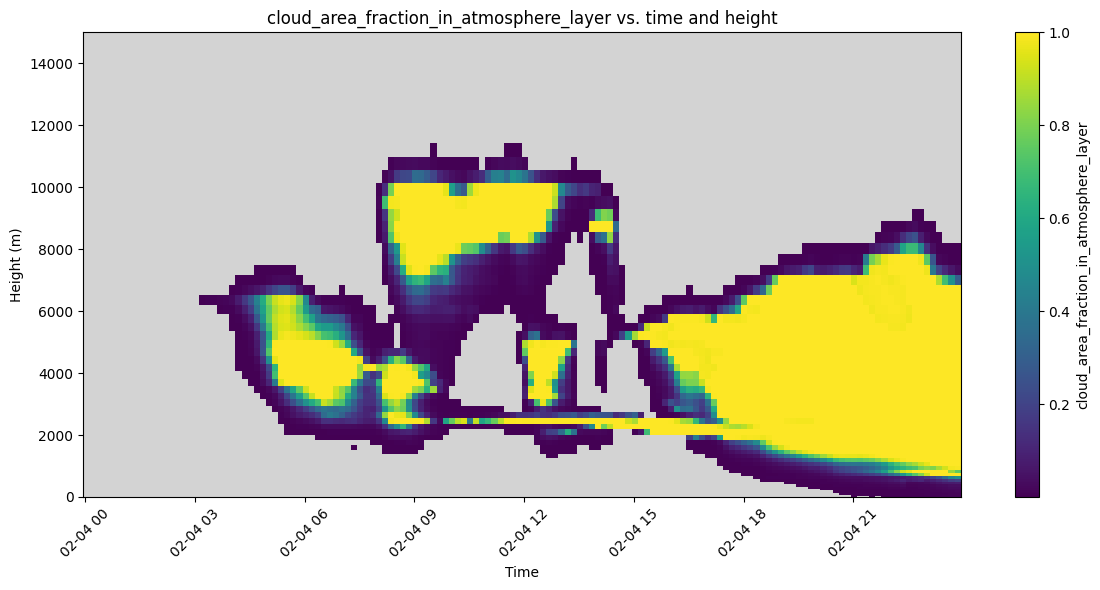

In [91]:
# nc

final_dataset = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/output/for_plotting/um_emc2_test_20180204.nc')

# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(final_dataset['time'], final_dataset['level_height'])

# Set the height limit for the plots
ylim_max = 15000

# Extract the desired variable
cloud_area_fraction_in_atmosphere_layer = final_dataset['cloud_area_fraction_in_atmosphere_layer']
# Set cloud_area_fraction_in_atmosphere_layer values equal to 0 to grey
cloud_area_fraction_in_atmosphere_layer_grey = np.where(cloud_area_fraction_in_atmosphere_layer == 0, np.nan, cloud_area_fraction_in_atmosphere_layer)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, cloud_area_fraction_in_atmosphere_layer_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'cloud_area_fraction_in_atmosphere_layer')
plt.title('cloud_area_fraction_in_atmosphere_layer vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_cloud_area_fraction_in_atmosphere_layer = plt.gcf()

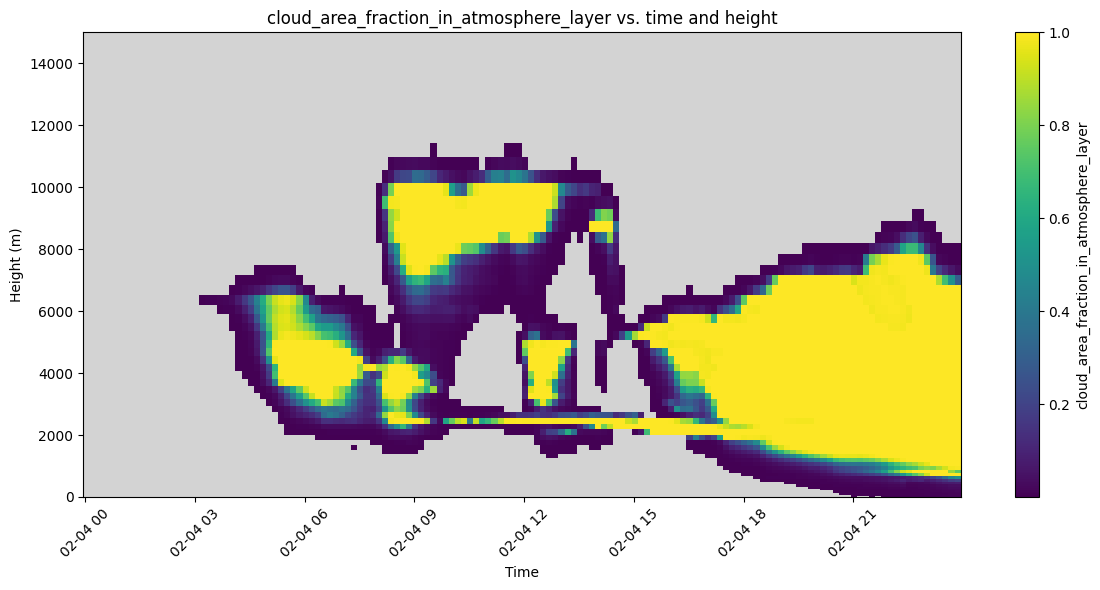

In [69]:
# pp

final_dataset = xr.open_dataset('/g/data/jk72/ck4840/projects/um_emc2/data/output/for_plotting/um_emc2_test_20180204_pp.nc')

# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(final_dataset['time'], final_dataset['level_height'])

# Set the height limit for the plots
ylim_max = 15000

# Extract the desired variable
cloud_area_fraction_in_atmosphere_layer = final_dataset['cloud_area_fraction_in_atmosphere_layer']
# Set cloud_area_fraction_in_atmosphere_layer values equal to 0 to grey
cloud_area_fraction_in_atmosphere_layer_grey = np.where(cloud_area_fraction_in_atmosphere_layer == 0, np.nan, cloud_area_fraction_in_atmosphere_layer)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, cloud_area_fraction_in_atmosphere_layer_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'cloud_area_fraction_in_atmosphere_layer')
plt.title('cloud_area_fraction_in_atmosphere_layer vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_cloud_area_fraction_in_atmosphere_layer = plt.gcf()

In [39]:
# # Create test plots of atmospheric properties from the processed UM output
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# # Create a meshgrid for time and height to be used for all plots produced from the current file
# time_mesh, height_mesh = np.meshgrid(test['time'], test['level_height'])

# # Set the height limit for the plots
# ylim_max = 15000

# # QCL
# # Extract the desired variable
# QCL = test['mass_fraction_of_cloud_liquid_water_in_air']
# # Set QCL values equal to 0 to grey
# QCL_grey = np.where(QCL == 0, np.nan, QCL)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, QCL_grey.T, cmap = 'viridis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'QCL (kg/kg)')
# plt.title('Cloud liquid mass mixing ratio vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_QCL = plt.gcf()

# # QCF
# # Extract the desired variable
# QCF = test['mass_fraction_of_cloud_ice_crystals_in_air']
# # Set QCF values equal to 0 to grey
# QCF_grey = np.where(QCF == 0, np.nan, QCF)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, QCF_grey.T, cmap = 'viridis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'QCF (kg/kg)')
# plt.title('Cloud ice mass mixing ratio vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_QCF = plt.gcf()

# # QPL
# # Extract the desired variable
# QPL = test['mass_fraction_of_rain_in_air']
# # Set QPL values equal to 0 to grey
# QPL_grey = np.where(QPL == 0, np.nan, QPL)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, QPL_grey.T, cmap = 'viridis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'QPL (kg/kg)')
# plt.title('Precip. liquid mass mixing ratio vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_QPL = plt.gcf()

# # QPF
# # Extract the desired variable
# QPF = test['mass_fraction_of_cloud_ice_in_air']
# # Set QPF values equal to 0 to grey
# QPF_grey = np.where(QPF == 0, np.nan, QPF)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, QPF_grey.T, cmap = 'viridis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'QPF (kg/kg)')
# plt.title('Precip. ice mass mixing ratio vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_QPF = plt.gcf()

# # QPG
# # Extract the desired variable
# QPG = test['mass_fraction_of_graupel_in_air']
# # Set QPG values equal to 0 to grey
# QPG_grey = np.where(QPG == 0, np.nan, QPG)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, QPG_grey.T, cmap = 'viridis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'QPG (kg/kg)')
# plt.title('Precip. graupel mass mixing ratio vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_QPG = plt.gcf()

# # NCL
# # Extract the desired variable
# NCL = test['number_of_cloud_droplets_per_kg_of_air']
# # Set NCL values equal to 0 to grey
# NCL_grey = np.where(NCL == 0, np.nan, NCL)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, NCL_grey.T, cmap = 'inferno', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'NCL (m^-3)')
# plt.title('Cloud liquid number concentration vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_NCL = plt.gcf()

# # NCF
# # Extract the desired variable
# NCF = test['number_of_ice_particles_per_kg_of_air']
# # Set NCF values equal to 0 to grey
# NCF_grey = np.where(NCF == 0, np.nan, NCF)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, NCF_grey.T, cmap = 'inferno', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'NCF (m^-3)')
# plt.title('Cloud ice number concentration vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_NCF = plt.gcf()

# # NPL
# # Extract the desired variable
# NPL = test['number_of_rain_drops_per_kg_of_air']
# # Set NPL values equal to 0 to grey
# NPL_grey = np.where(NPL == 0, np.nan, NPL)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, NPL_grey.T, cmap = 'inferno', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'NPL (m^-3)')
# plt.title('Precip. liquid number concentration vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_NPL = plt.gcf()

# # NPF
# # Extract the desired variable
# NPF = test['number_of_snow_aggregates_per_kg_of_air']
# # Set NPF values equal to 0 to grey
# NPF_grey = np.where(NPF == 0, np.nan, NPF)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, NPF_grey.T, cmap = 'inferno', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'NPF (m^-3)')
# plt.title('Precip. ice number concentration vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_NPF = plt.gcf()

# # NPG
# # Extract the desired variable
# NPG = test['number_of_graupel_particles_per_kg_of_air']
# # Set NPG values equal to 0 to grey
# NPG_grey = np.where(NPG == 0, np.nan, NPG)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, NPG_grey.T, cmap = 'inferno', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'NPG (m^-3)')
# plt.title('Precip. graupel number concentration vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_NPG = plt.gcf()

# # Cloud stratiform fraction
# # Extract the desired variable
# strat_frac = test['cloud_area_fraction_in_atmosphere_layer']
# # Set strat_frac values equal to 0 to grey
# strat_frac_grey = np.where(strat_frac == 0, np.nan, strat_frac)
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, strat_frac_grey.T, cmap = 'magma', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Cloud stratiform fraction')
# plt.title('Cloud area fraction vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_strat_frac = plt.gcf()

# # Specific humidity
# # Extract the desired variable
# hus = test['specific_humidity']
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, hus.T, cmap = 'cividis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Specific humidity')
# plt.title('Specific humidity vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_hus = plt.gcf()

# # Pressure
# # Extract the desired variable
# pressure = test['air_pressure']
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, pressure.T, cmap = 'cividis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Pressure (Pa)')
# plt.title('Pressure vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_pressure = plt.gcf()

# # Temperature
# # Extract the desired variable
# temperature = test['air_temperature']
# # Create the plot with a grey background
# plt.figure(figsize = (12, 6))
# plt.gca().set_facecolor('lightgrey')
# # Create and organise a pcolormesh plot
# pcm = plt.pcolormesh(time_mesh, height_mesh, temperature.T, cmap = 'cividis', shading = 'auto')
# plt.xlabel('Time')
# plt.ylabel('Height (m)')
# plt.colorbar(pcm, label = 'Temperature (K)')
# plt.title('Temperature vs. time and height')
# plt.ylim(0, ylim_max)
# plt.xticks(rotation = 45)
# plt.tight_layout()
# daily_UM_reg_temperature = plt.gcf()

# print('Finished plotting')